# Merger Parameterisation Testing

Preliminary Code

In [7]:
# Import libraries
import numpy as np
import marvin
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [8]:
from marvin import config
config.access

'public'

In [9]:
config.setDR('DR17')
config.release

'DR17'

Code taken from GitHub Issues page to fix API error

In [10]:
from marvin import config
config.switchSasUrl(sasmode='mirror')

## Unnormalised Residual Velocity Method

As a proof of concept, implement unnormalised residual velocity technique for one galaxy

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


Min of abs_res:  0.0
Max of abs_res:  58.03580500000001
sum_res_val:  29688.2294755864


[WARNING]: Warning: converting a masked element to nan. (UserWarning)


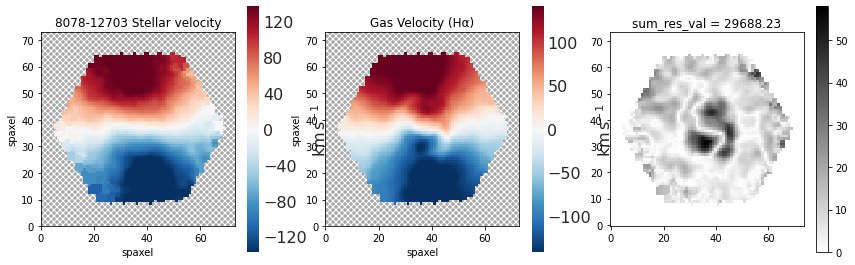

In [13]:
from marvin.tools import Maps

# Load in test map (bottom-left of Smethurst et al., 2018)
maps = Maps("8078-12703")

# Select stellar and gas velocity (H-alpha)
sv = maps.stellar_vel
gv = maps.emline_gvel_ha_6564

# Calculate absolute residual velocity value
abs_res = np.abs(sv.value - gv.value)
print("Min of abs_res: ", np.min(abs_res))
print("Max of abs_res: ", np.max(abs_res))

# Transform map into set of values
res_vals = np.abs(sv.value - gv.value)

# Calculate summed absolute residual velocity value
sum_res_val = np.sum(res_vals)
print("sum_res_val: ", sum_res_val)

# Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
x = np.arange(num_xy)
y = np.arange(num_xy)

# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()

# Plot stellar, gas velocities
sv.plot(fig=fig, ax=ax[0], title="8078-12703 Stellar velocity")
gv.plot(fig=fig, ax=ax[1], title="Gas Velocity (Hα)")

# Plot absolute residual colormap
rv_pcolormesh = ax[2].pcolormesh(x, y, res_vals, cmap=cm.binary, shading="auto")
fig.colorbar(rv_pcolormesh, ax=ax[2])

ax[2].set_title("sum_res_val = " + "{:.2f}".format(sum_res_val))
ax[2].set_aspect("equal")

Now implement for all galaxies in sample, looping over each kinematic classification individually

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


i =  0
MaNGA ID:  8600-12703
Min of res_vals:  0.0
Max of res_vals:  2161.522825
sum_res_val:  469331.73474568396


[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


i =  1
MaNGA ID:  8466-6103
Min of res_vals:  0.0
Max of res_vals:  1714.641518
sum_res_val:  189491.11500065998


[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


i =  2
MaNGA ID:  8726-1901
Min of res_vals:  0.0
Max of res_vals:  1065.7605079999998
sum_res_val:  34451.864503396006
i =  3
MaNGA ID:  8721-12701
Min of res_vals:  0.0
Max of res_vals:  2171.6790800000003
sum_res_val:  715319.038034361
i =  4
MaNGA ID:  8481-6101
Min of res_vals:  0.0
Max of res_vals:  435.77882
sum_res_val:  61264.87093388599
i =  5
MaNGA ID:  8725-1902
Min of res_vals:  0.0
Max of res_vals:  438.37255569999996
sum_res_val:  39689.6838930031
i =  6
MaNGA ID:  8078-12703
Min of res_vals:  0.0
Max of res_vals:  58.03580500000001
sum_res_val:  29688.2294755864
i =  7
MaNGA ID:  8615-6104
Min of res_vals:  0.0
Max of res_vals:  11069.31798
sum_res_val:  65903.44629189
i =  8
MaNGA ID:  8597-1902
Min of res_vals:  0.0
Max of res_vals:  769.233052
sum_res_val:  47149.763534159996
i =  9
MaNGA ID:  8485-1901
Min of res_vals:  0.0
Max of res_vals:  261.634157
sum_res_val:  19263.66031111


[WARNING]: Warning: converting a masked element to nan. (UserWarning)


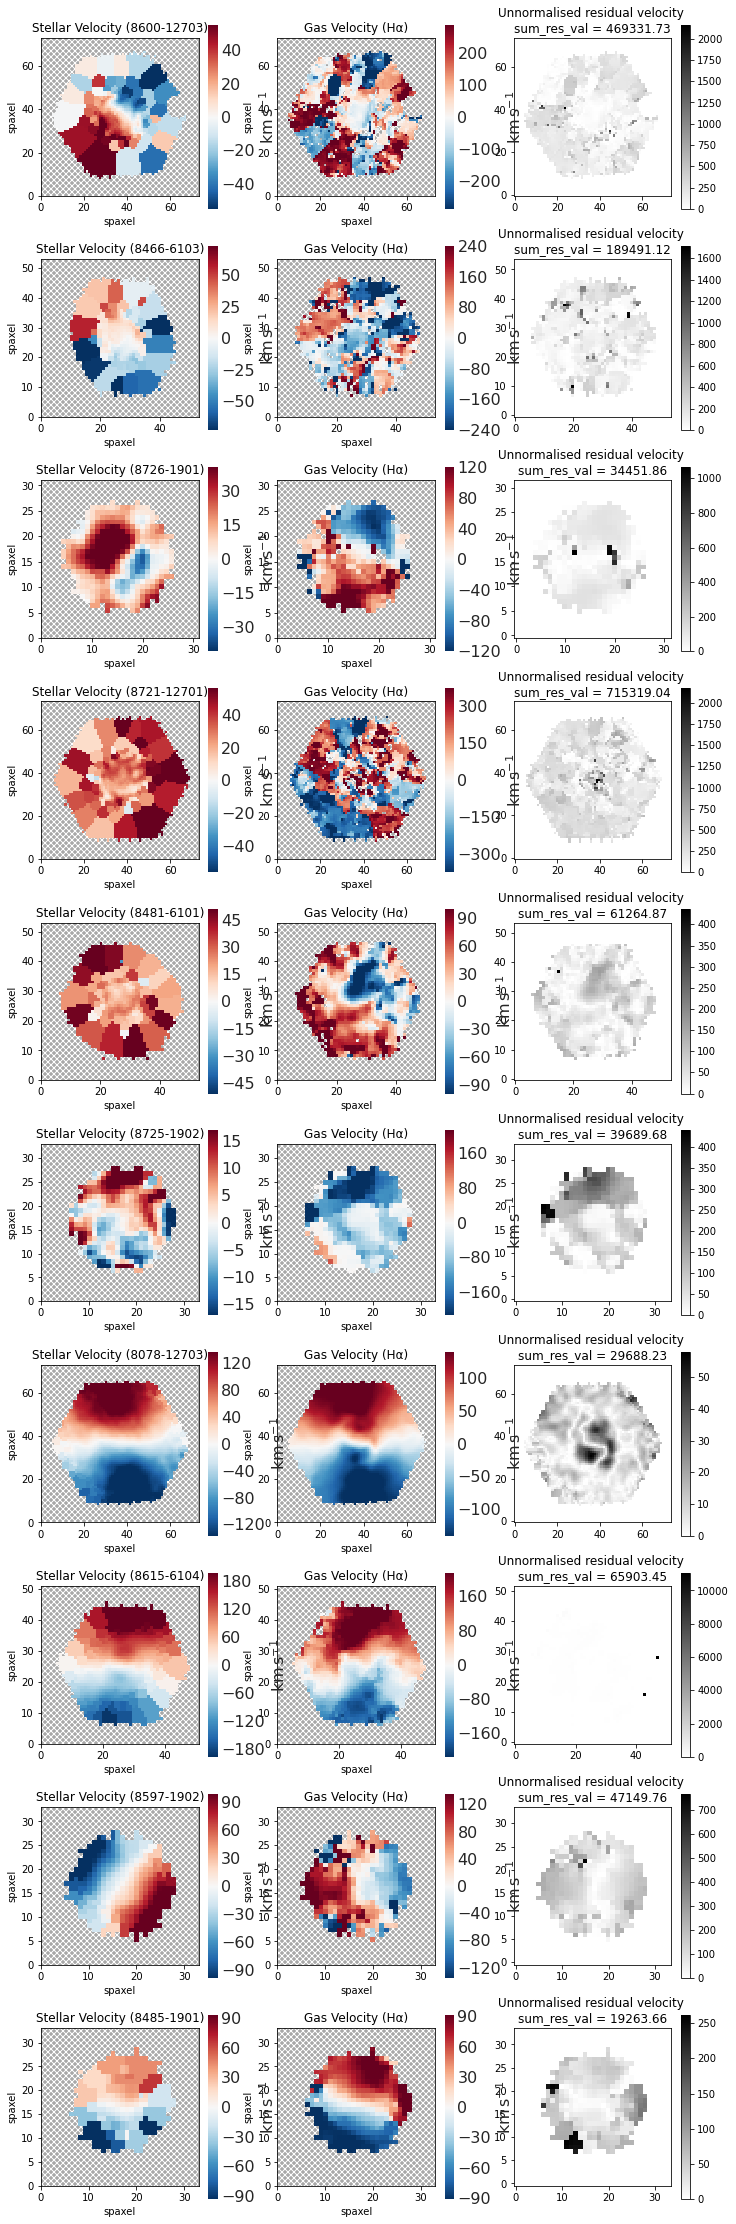

In [48]:
from marvin.tools import Maps

# MaNGA codes for each class of rotator
non_reg_ids = ['8600-12703', '8466-6103', '8726-1901']
slow_rot_ids = ['8721-12701', '8481-6101', '8725-1902']
fast_rot_ids = ['8078-12703', '8615-6104', '8597-1902', '8485-1901']

# Combined set of ids (in case studying as one dataset is more helpful/efficient)
combined_ids = non_reg_ids + slow_rot_ids + fast_rot_ids

# Initialise arrays to store data for analysis
nr_rv_array = np.zeros(len(non_reg_ids))  # store unnormalised rv value for non-regular rotators
sr_rv_array = np.zeros(len(slow_rot_ids))  # store unnormalised rv value for slow rotators
fr_rv_array = np.zeros(len(fast_rot_ids))  # store unnormalised rv value for fast rotators

# Plot initial figure and axes
fig, ax = plt.subplots(nrows=len(combined_ids), ncols=3, figsize=(12, 4*len(combined_ids)))

# Non-regular rotators
for i in range(len(non_reg_ids)):
    # Access map of ith galaxy
    maps = Maps(non_reg_ids[i])

    # Select stellar and gas velocity (H-alpha)
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564

    # Create residual image
    res = sv - gv
    
    print("i = ", i)
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", non_reg_ids[i])
    
    # Transform map into set of values
    res_vals = np.abs(sv.value - gv.value)
    print("Min of res_vals: ", np.min(res_vals))
    print("Max of res_vals: ", np.max(res_vals))
    
    # Calculate summed absolute residual velocity value and add to rv array
    sum_res_val = np.sum(res_vals)
    nr_rv_array[i] = sum_res_val
    print("sum_res_val: ", sum_res_val)
    
    # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
    num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
    x = np.arange(num_xy)
    y = np.arange(num_xy)

    # Plot stellar and gas velocities
    sv.plot(fig=fig, ax=ax[i, 0], title="Stellar Velocity (" + str(non_reg_ids[i]) + ")")
    gv.plot(fig=fig, ax=ax[i, 1], title="Gas Velocity (Hα)")
    
    # Plot absolute residual colormap
    rv_pcolormesh = ax[i, 2].pcolormesh(x, y, res_vals, cmap=cm.binary, shading="auto")
    fig.colorbar(rv_pcolormesh, ax=ax[i, 2])

    ax[i, 2].set_title("Unnormalised residual velocity \nsum_res_val = " + "{:.2f}".format(sum_res_val))
    ax[i, 2].set_aspect("equal")
    
# Slow rotators
for i in range(len(slow_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(slow_rot_ids[i])

    # Select stellar and gas velocity (H-alpha)
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564
    
    print("i = ", i + len(non_reg_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", slow_rot_ids[i])
    
    # Transform map into set of values
    res_vals = np.abs(sv.value - gv.value)
    print("Min of res_vals: ", np.min(res_vals))
    print("Max of res_vals: ", np.max(res_vals))

    # Calculate summed absolute residual velocity value and add to rv array
    sum_res_val = np.sum(res_vals)
    sr_rv_array[i] = sum_res_val
    print("sum_res_val: ", sum_res_val)
    
    # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
    num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
    x = np.arange(num_xy)
    y = np.arange(num_xy)

    # Plot stellar and gas velocities
    sv.plot(fig=fig, ax=ax[i+len(non_reg_ids), 0], title="Stellar Velocity (" + str(slow_rot_ids[i]) + ")")
    gv.plot(fig=fig, ax=ax[i+len(non_reg_ids), 1], title="Gas Velocity (Hα)")
    
    # Plot absolute residual colormap
    rv_pcolormesh = ax[i+len(non_reg_ids), 2].pcolormesh(x, y, res_vals, cmap=cm.binary, shading="auto")
    fig.colorbar(rv_pcolormesh, ax=ax[i+len(non_reg_ids), 2])

    ax[i+len(non_reg_ids), 2].set_title("Unnormalised residual velocity \nsum_res_val = " + "{:.2f}".format(sum_res_val))
    ax[i+len(non_reg_ids), 2].set_aspect("equal")
    
# Fast rotators
for i in range(len(fast_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(fast_rot_ids[i])
    
    # Select stellar and gas velocity (H-alpha)
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564
    
    print("i = ", i + len(non_reg_ids) + len(slow_rot_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", fast_rot_ids[i])
    
    # Transform map into set of values
    res_vals = np.abs(sv.value - gv.value)
    print("Min of res_vals: ", np.min(res_vals))
    print("Max of res_vals: ", np.max(res_vals))

   # Calculate summed absolute residual velocity value and add to rv array
    sum_res_val = np.sum(res_vals)
    fr_rv_array[i] = sum_res_val
    print("sum_res_val: ", sum_res_val)
    
    # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
    num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
    x = np.arange(num_xy)
    y = np.arange(num_xy)

    # Plot stellar and gas velocities
    sv.plot(fig=fig, ax=ax[i+len(non_reg_ids)+len(slow_rot_ids), 0], title="Stellar Velocity (" + str(fast_rot_ids[i]) + ")")
    gv.plot(fig=fig, ax=ax[i+len(non_reg_ids)+len(slow_rot_ids), 1], title="Gas Velocity (Hα)")
    
    # Plot absolute residual velocity colormap
    rv_pcolormesh = ax[i+len(non_reg_ids)+len(slow_rot_ids), 2].pcolormesh(x, y, res_vals, cmap=cm.binary, shading="auto")
    fig.colorbar(rv_pcolormesh, ax=ax[i+len(non_reg_ids)+len(slow_rot_ids), 2])
    
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 2].set_title("Unnormalised residual velocity \nsum_res_val = " + "{:.2f}".format(sum_res_val))
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 2].set_aspect("equal")

## Normalised Residual Velocity Method

As a proof of concept, implement normalised residual velocity technique for one galaxy

sum_res_val:  160.37746982916917


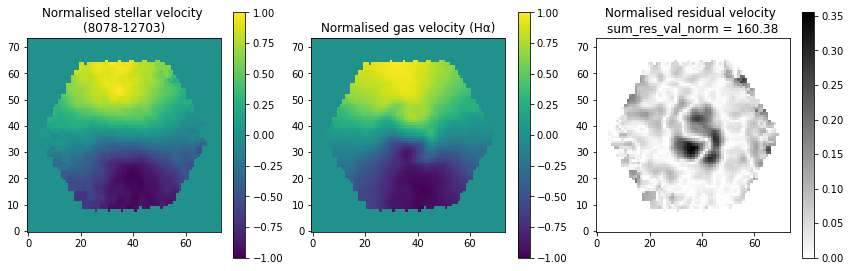

In [46]:
# Use same test example as with unnormalised residual velocity method
maps = Maps('8078-12703')

# Select stellar and gas velocity
sv = maps.stellar_vel
gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha

# Normalise stellar velocity
sv_pos = np.maximum(0, sv.value)
sv_neg = np.minimum(0, sv.value)

sv_pos_norm = sv_pos / np.max(sv_pos)
sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

sv_norm = sv_pos_norm + sv_neg_norm

# Normalise gas velocity
gv_pos = np.maximum(0, gv.value)
gv_neg = np.minimum(0, gv.value)

gv_pos_norm = gv_pos / np.max(gv_pos)
gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

gv_norm = gv_pos_norm + gv_neg_norm

# Calculate residual velocity values
res_vals_norm = np.abs(sv_norm - gv_norm)
print("Min of res_vals: ", np.min(res_vals_norm))
print("Max of res_vals: ", np.max(res_vals_norm))

# Calculate summed absolute residual velocity value
sum_res_val_norm = np.sum(res_vals_norm)
print("sum_res_val: ", sum_res_val_norm)

# Create figure (& extra plotting code)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()

# Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
x = np.arange(num_xy)
y = np.arange(num_xy)

# Plot normalised stellar velocity
sv_pcolormesh = ax[0].pcolormesh(x, y, sv_norm, shading="auto")
fig.colorbar(sv_pcolormesh, ax=ax[0])
ax[0].set_title("Normalised stellar velocity \n(8078-12703)")
ax[0].set_aspect('equal')

# Plot normalised gas velocity
gv_pcolormesh = ax[1].pcolormesh(x, y, gv_norm, shading="auto")
fig.colorbar(gv_pcolormesh, ax=ax[1])
ax[1].set_title("Normalised gas velocity (Hα)")
ax[1].set_aspect('equal')

# Plot absolute residual velocity colormap
rv_pcolormesh = ax[2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
fig.colorbar(rv_pcolormesh, ax=ax[2])
ax[2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
ax[2].set_aspect("equal")

Now implement for all galaxies in sample, looping over each kinematic classification individually

i =  0
MaNGA ID:  8600-12703
Min of res_vals:  0.0
Max of res_vals:  1.4290146955964214
sum_res_val:  998.688878693155
i =  1
MaNGA ID:  8466-6103
Min of res_vals:  0.0
Max of res_vals:  1.3435667478526832
sum_res_val:  513.7092709047558
i =  2
MaNGA ID:  8726-1901
Min of res_vals:  0.0
Max of res_vals:  1.7633913274427635
sum_res_val:  165.04081088198149
i =  3
MaNGA ID:  8721-12701
Min of res_vals:  0.0
Max of res_vals:  1.6203281839419252
sum_res_val:  1514.5969679397429
i =  4
MaNGA ID:  8481-6101
Min of res_vals:  0.0
Max of res_vals:  1.657696835527021
sum_res_val:  430.1827638888621
i =  5
MaNGA ID:  8725-1902
Min of res_vals:  0.0
Max of res_vals:  1.6398926928004498
sum_res_val:  157.2352463646975
i =  6
MaNGA ID:  8078-12703
Min of res_vals:  0.0
Max of res_vals:  0.35497622705802023
sum_res_val:  160.37746982916917
i =  7
MaNGA ID:  8615-6104
Min of res_vals:  0.0
Max of res_vals:  1.2107270396962058
sum_res_val:  329.82837859414184
i =  8
MaNGA ID:  8597-1902
Min of res_val

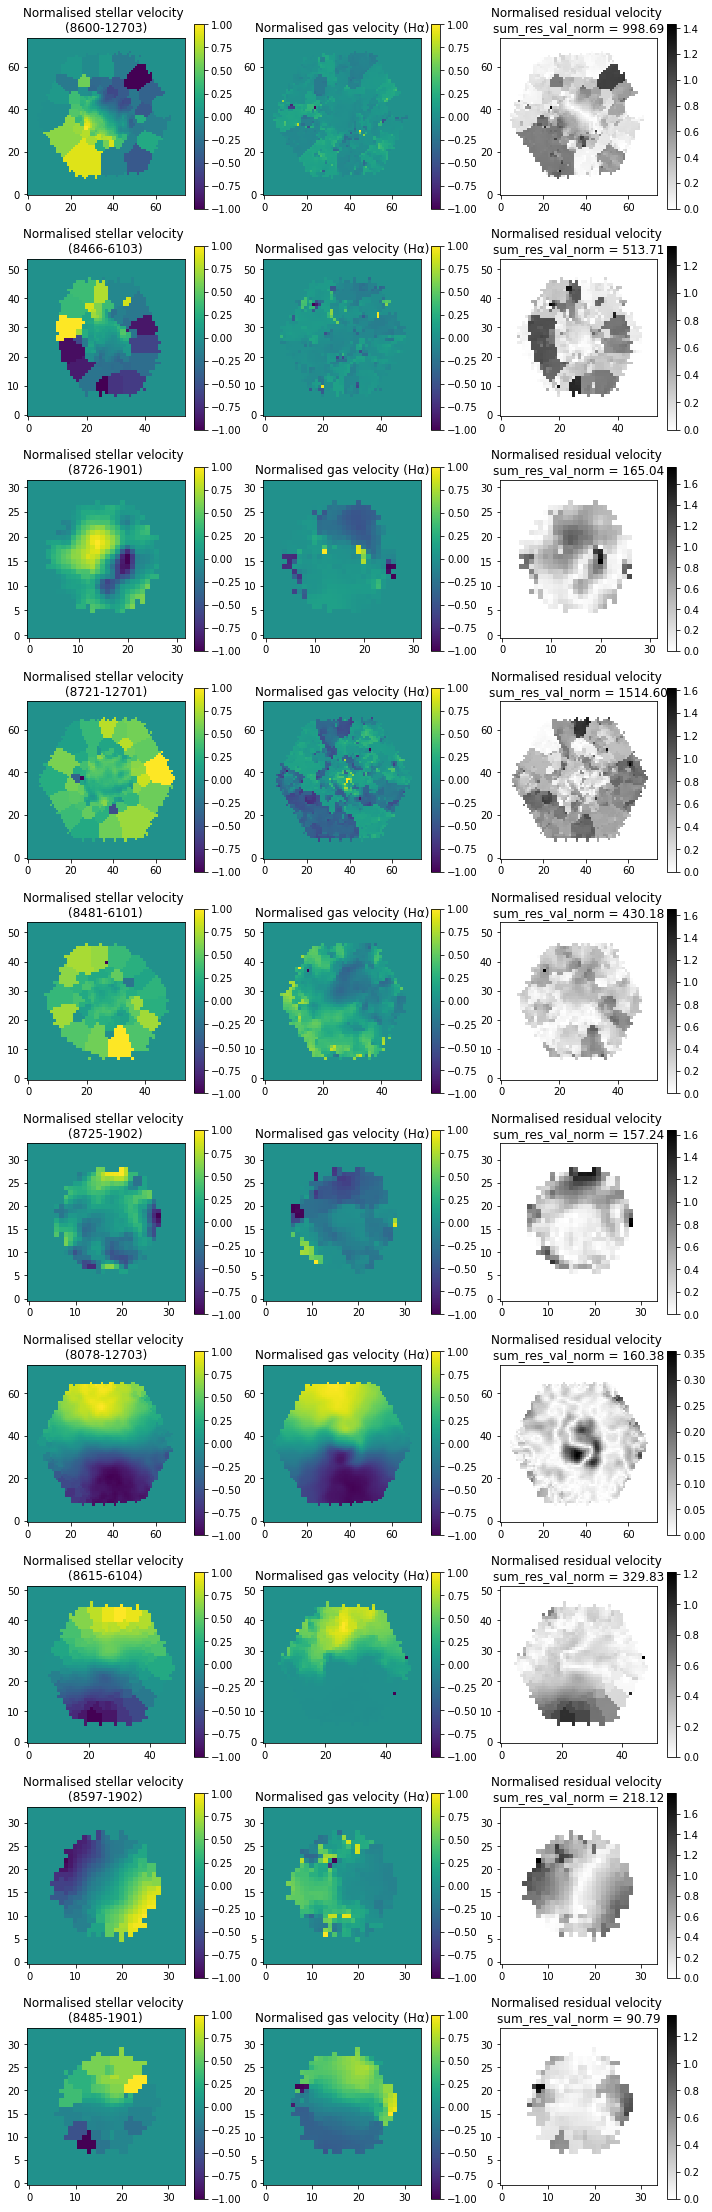

In [56]:
from marvin.tools import Maps

# MaNGA codes for each class of rotator
non_reg_ids = ['8600-12703', '8466-6103', '8726-1901']
slow_rot_ids = ['8721-12701', '8481-6101', '8725-1902']
fast_rot_ids = ['8078-12703', '8615-6104', '8597-1902', '8485-1901']

# Combined set of ids (in case studying as one dataset is more helpful/efficient)
combined_ids = non_reg_ids + slow_rot_ids + fast_rot_ids

# Initialise arrays to store data for analysis
nr_rv_norm_array = np.zeros(len(non_reg_ids))  # store normalised rv value for non-regular rotators
sr_rv_norm_array = np.zeros(len(slow_rot_ids))  # store normalised rv value for slow rotators
fr_rv_norm_array = np.zeros(len(fast_rot_ids))  # store normalised rv value for fast rotators

# Plot initial figure and axes
fig, ax = plt.subplots(nrows=len(combined_ids), ncols=3, figsize=(12, 4*len(combined_ids)))

# Non-regular rotators
for i in range(len(non_reg_ids)):
    # Access map of ith galaxy
    maps = Maps(non_reg_ids[i])
    
    print("i = ", i)
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", non_reg_ids[i])

    # Select stellar and gas velocity
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha
    
    # Normalise stellar velocity
    sv_pos = np.maximum(0, sv.value)
    sv_neg = np.minimum(0, sv.value)
    
    sv_pos_norm = sv_pos / np.max(sv_pos)
    sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

    sv_norm = sv_pos_norm + sv_neg_norm

    # Normalise gas velocity
    gv_pos = np.maximum(0, gv.value)
    gv_neg = np.minimum(0, gv.value)

    gv_pos_norm = gv_pos / np.max(gv_pos)
    gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

    gv_norm = gv_pos_norm + gv_neg_norm
    
    # Calculate residual velocity values
    res_vals_norm = np.abs(sv_norm - gv_norm)
    print("Min of res_vals: ", np.min(res_vals_norm))
    print("Max of res_vals: ", np.max(res_vals_norm))

    # Calculate summed absolute residual velocity value and add to normalised rv array
    sum_res_val_norm = np.sum(res_vals_norm)
    nr_rv_norm_array[i] = sum_res_val_norm
    print("sum_res_val: ", sum_res_val_norm)
    
    # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
    num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
    x = np.arange(num_xy)
    y = np.arange(num_xy)
    
    # Plot normalised stellar velocity
    sv_pcolormesh = ax[i, 0].pcolormesh(x, y, sv_norm, shading="auto")
    fig.colorbar(sv_pcolormesh, ax=ax[i, 0])
    ax[i, 0].set_title("Normalised stellar velocity \n(" + str(non_reg_ids[i]) + ")")
    ax[i, 0].set_aspect('equal')
    
    # Plot normalised gas velocity
    gv_pcolormesh = ax[i, 1].pcolormesh(x, y, gv_norm, shading="auto")
    fig.colorbar(gv_pcolormesh, ax=ax[i, 1])
    ax[i, 1].set_title("Normalised gas velocity (Hα)")
    ax[i, 1].set_aspect('equal')
    
    # Plot absolute residual colormap
    rv_pcolormesh = ax[i, 2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
    fig.colorbar(rv_pcolormesh, ax=ax[i, 2])
    ax[i, 2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
    ax[i, 2].set_aspect("equal")
    
# Slow rotators
for i in range(len(slow_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(slow_rot_ids[i])
    
    print("i = ", i + len(non_reg_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", slow_rot_ids[i])

    # Select stellar and gas velocity
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha
    
    # Normalise stellar velocity
    sv_pos = np.maximum(0, sv.value)
    sv_neg = np.minimum(0, sv.value)
    
    sv_pos_norm = sv_pos / np.max(sv_pos)
    sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

    sv_norm = sv_pos_norm + sv_neg_norm

    # Normalise gas velocity
    gv_pos = np.maximum(0, gv.value)
    gv_neg = np.minimum(0, gv.value)

    gv_pos_norm = gv_pos / np.max(gv_pos)
    gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

    gv_norm = gv_pos_norm + gv_neg_norm
    
    # Calculate residual velocity values
    res_vals_norm = np.abs(sv_norm - gv_norm)
    print("Min of res_vals: ", np.min(res_vals_norm))
    print("Max of res_vals: ", np.max(res_vals_norm))

    # Calculate summed absolute residual velocity value and add to normalised rv array
    sum_res_val_norm = np.sum(res_vals_norm)
    sr_rv_norm_array[i] = sum_res_val_norm
    print("sum_res_val: ", sum_res_val_norm)
    
    # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
    num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
    x = np.arange(num_xy)
    y = np.arange(num_xy)

    # Plot normalised stellar velocity
    sv_pcolormesh = ax[i+len(non_reg_ids), 0].pcolormesh(x, y, sv_norm, shading="auto")
    fig.colorbar(sv_pcolormesh, ax=ax[i+len(non_reg_ids), 0])
    ax[i+len(non_reg_ids), 0].set_title("Normalised stellar velocity \n(" + str(slow_rot_ids[i]) + ")")
    ax[i+len(non_reg_ids), 0].set_aspect('equal')
    
    # Plot normalised gas velocity
    gv_pcolormesh = ax[i+len(non_reg_ids), 1].pcolormesh(x, y, gv_norm, shading="auto")
    fig.colorbar(gv_pcolormesh, ax=ax[i+len(non_reg_ids), 1])
    ax[i+len(non_reg_ids), 1].set_title("Normalised gas velocity (Hα)")
    ax[i+len(non_reg_ids), 1].set_aspect('equal')
    
    # Plot absolute residual colormap
    rv_pcolormesh = ax[i+len(non_reg_ids), 2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
    fig.colorbar(rv_pcolormesh, ax=ax[i+len(non_reg_ids), 2])

    ax[i+len(non_reg_ids), 2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
    ax[i+len(non_reg_ids), 2].set_aspect("equal")
    
# Fast rotators
for i in range(len(fast_rot_ids)):
    # Access map of ith galaxy
    maps = Maps(fast_rot_ids[i])
    
    print("i = ", i + len(non_reg_ids) + len(slow_rot_ids))
    
    # Print MaNGA ID for checking
    print("MaNGA ID: ", fast_rot_ids[i])

    # Select stellar and gas velocity
    sv = maps.stellar_vel
    gv = maps.emline_gvel_ha_6564  # Gas velocity of H-alpha
    
    # Normalise stellar velocity
    sv_pos = np.maximum(0, sv.value)
    sv_neg = np.minimum(0, sv.value)
    
    sv_pos_norm = sv_pos / np.max(sv_pos)
    sv_neg_norm = sv_neg / np.abs(np.min(sv_neg))

    sv_norm = sv_pos_norm + sv_neg_norm

    # Normalise gas velocity
    gv_pos = np.maximum(0, gv.value)
    gv_neg = np.minimum(0, gv.value)

    gv_pos_norm = gv_pos / np.max(gv_pos)
    gv_neg_norm = gv_neg / np.abs(np.min(gv_neg))

    gv_norm = gv_pos_norm + gv_neg_norm
    
    # Calculate residual velocity values
    res_vals_norm = np.abs(sv_norm - gv_norm)
    print("Min of res_vals: ", np.min(res_vals_norm))
    print("Max of res_vals: ", np.max(res_vals_norm))

    # Calculate summed absolute residual velocity value and add to normalised rv array
    sum_res_val_norm = np.sum(res_vals_norm)
    fr_rv_norm_array[i] = sum_res_val_norm
    print("sum_res_val: ", sum_res_val_norm)
    
    # Use Marvin x and y values to obtain shape of arrays to plot colormap of absolute residual
    num_xy = np.size(maps.spx_skycoo_on_sky_x[0])
    x = np.arange(num_xy)
    y = np.arange(num_xy)

    # Plot normalised stellar velocity
    sv_pcolormesh = ax[i+len(non_reg_ids)+len(slow_rot_ids), 0].pcolormesh(x, y, sv_norm, shading="auto")
    fig.colorbar(sv_pcolormesh, ax=ax[i+len(non_reg_ids)+len(slow_rot_ids), 0])
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 0].set_title("Normalised stellar velocity \n(" + str(fast_rot_ids[i]) + ")")
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 0].set_aspect('equal')
    
    # Plot normalised gas velocity
    gv_pcolormesh = ax[i+len(non_reg_ids)+len(slow_rot_ids), 1].pcolormesh(x, y, gv_norm, shading="auto")
    fig.colorbar(gv_pcolormesh, ax=ax[i+len(non_reg_ids)+len(slow_rot_ids), 1])
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 1].set_title("Normalised gas velocity (Hα)")
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 1].set_aspect('equal')
    
    # Plot absolute residual colormap
    rv_pcolormesh = ax[i+len(non_reg_ids)+len(slow_rot_ids), 2].pcolormesh(x, y, res_vals_norm, cmap=cm.binary, shading="auto")
    fig.colorbar(rv_pcolormesh, ax=ax[i+len(non_reg_ids)+len(slow_rot_ids), 2])

    ax[i+len(non_reg_ids)+len(slow_rot_ids), 2].set_title("Normalised residual velocity \nsum_res_val_norm = " + "{:.2f}".format(sum_res_val_norm))
    ax[i+len(non_reg_ids)+len(slow_rot_ids), 2].set_aspect("equal")

## Analysis of unnormalised RV vs normalised RV

In [71]:
# Print all arrays from unnormalised rv (kinematically distinguished)
print("nr_rv_array: ", nr_rv_array)
print("sr_rv_array: ", sr_rv_array)
print("fr_rv_array: ", fr_rv_array)

# Print all arrays from normalised rv (kinematically distinguished)
print("nr_rv_norm_array: ", nr_rv_norm_array)
print("sr_rv_norm_array: ", sr_rv_norm_array)
print("fr_rv_norm_array: ", fr_rv_norm_array)

nr_rv_array:  [469331.73474568 189491.11500066  34451.8645034 ]
sr_rv_array:  [715319.03803436  61264.87093389  39689.683893  ]
fr_rv_array:  [29688.22947559 65903.44629189 47149.76353416 19263.66031111]
nr_rv_norm_array:  [998.68887869 513.7092709  165.04081088]
sr_rv_norm_array:  [1514.59696794  430.18276389  157.23524636]
fr_rv_norm_array:  [160.37746983 329.82837859 218.12118095  90.78983503]


### Explore relation between unnormalised rv and normalised rv

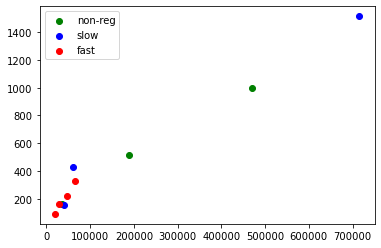

In [70]:
# stack each kinematic class together
nr_stack = np.column_stack((nr_rv_array, nr_rv_norm_array))
sr_stack = np.column_stack((sr_rv_array, sr_rv_norm_array))
fr_stack = np.column_stack((fr_rv_array, fr_rv_norm_array))

plt.scatter(nr_rv_array, nr_rv_norm_array, color="green", label="non-reg")
plt.scatter(sr_rv_array, sr_rv_norm_array, color="blue", label="slow")
plt.scatter(fr_rv_array, fr_rv_norm_array, color="red", label="fast")

plt.legend()

Relationship is fairly linear for all kinematic classes, suggesting that normalisation may not provide extra information compared with residual velocity

### Explore how (un)normalised rv tracks $\lambda_{Re}$

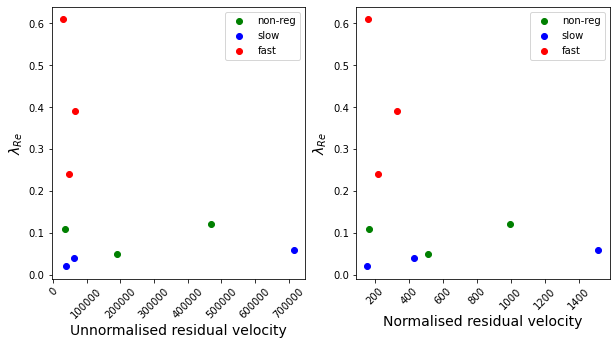

In [82]:
lambda_nr = np.array([0.12, 0.05, 0.11])
lambda_sr = np.array([0.06, 0.04, 0.02])
lambda_fr = np.array([0.61, 0.39, 0.24])  # Leave out extra galaxy until λ_Re known

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# Plot unnormalised rv against λ_Re
ax[0].scatter(nr_rv_array, lambda_nr, color="green", label="non-reg")
ax[0].scatter(sr_rv_array, lambda_sr, color="blue", label="slow")
ax[0].scatter(fr_rv_array[:3], lambda_fr, color="red", label="fast")

ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_xlabel("Unnormalised residual velocity", fontsize=14)
ax[0].set_ylabel("$\lambda_{Re}$", fontsize=14)
ax[0].legend()

# Plot normalised rv against λ_Re
ax[1].scatter(nr_rv_norm_array, lambda_nr, color="green", label="non-reg")
ax[1].scatter(sr_rv_norm_array, lambda_sr, color="blue", label="slow")
ax[1].scatter(fr_rv_norm_array[:3], lambda_fr, color="red", label="fast")

ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_xlabel("Normalised residual velocity", fontsize=14)
ax[1].set_ylabel("$\lambda_{Re}$", fontsize=14)
ax[1].legend()

Since the unnormalised-normalised rv relationship is linear, it is perhaps unsurprising that the distributions of the two methods' relation to $\lambda_{Re}$ is similar. 

Analysing these relations, given the spread in data along (un)normalised rv for non-regular and slow rotators, it seems that they cannot serve as a base indicators to constrain the kineamatic classification

Interestingly, fast rotators seem reasonably constrained by both methods, perhaps suggesting that they could be an indicator of rotational stability, and therefore evidence that the galaxy has *not* undergone a merger. However, since both slow and non-regular rotators also show low rv values, this may not be accurate

With more data, it could be that enough fast rotators stay below 400 (unnormalised) and slow and non-regular rotators move above 400. At that point, the claim about residual velocity being a predictor of being a fast rotator would have more strength 

### Explore the extent to which different kinematic classes have different (un)normalised rv mean values

In [91]:
# Calculate mean value for each kinematic class
nr_rv_mean = np.mean(nr_rv_array)
sr_rv_mean = np.mean(sr_rv_array)
fr_rv_mean = np.mean(fr_rv_array)

nr_rv_norm_mean = np.mean(nr_rv_norm_array)
sr_rv_norm_mean = np.mean(sr_rv_norm_array)
fr_rv_norm_mean = np.mean(fr_rv_norm_array)

print("nr_rv_mean: ", nr_rv_mean)
print("sr_rv_mean: ", sr_rv_mean)
print("fr_rv_mean: ", fr_rv_mean)

print("\nnr_rv_norm_mean: ", nr_rv_norm_mean)
print("sr_rv_norm_mean: ", sr_rv_norm_mean)
print("fr_rv_norm_mean: ", fr_rv_norm_mean)

# Divide all means by lowest one to see whether normalised and unnormalised means are proportional
print("\nnr_fr_rv_mean_ratio: ", nr_rv_mean / fr_rv_mean)
print("sr_fr_rv_mean_ratio: ", sr_rv_mean / fr_rv_mean)

print("\nnr_fr_rv_norm_mean_ratio: ", nr_rv_norm_mean / fr_rv_norm_mean)
print("sr_fr_rv_norm_mean_ratio: ", sr_rv_norm_mean / fr_rv_norm_mean)

nr_rv_mean:  231091.57141657997
sr_rv_mean:  272091.1976204167
fr_rv_mean:  40501.2749031866

nr_rv_norm_mean:  559.1463201599641
sr_rv_norm_mean:  700.6716593977675
fr_rv_norm_mean:  199.77921610102266

nr_fr_rv_mean_ratio:  5.705785113406342
sr_fr_rv_mean_ratio:  6.718089696455675

nr_fr_rv_norm_mean_ratio:  2.7988212741670773
sr_fr_rv_norm_mean_ratio:  3.507229996555086


The means of slow and mid rotators are substantially higher than fast rotators. This is a similar result to the $\lambda_{Re}$ discussion and, as such, more data would be needed to confirm the power of residual velocity in morphological classification

The ratios of the means are roughly half as small for normalised values. However *the ratio of the ratio of means* is roughly similar

### Test whether (un)normalised residual velocity corresponds with stellar mass